# Principal component analysis of large datasets

In this example, we perform dimensionality reduction of a large dataset (~75GB) using PCA. The dataset is 100000000 samples with 100 features, i.e., a "tall and skinny" matrix.

### Connect to the Dask cluster

First, we connect to a Dask cluster that is started by following the instructions [here](https://www.palmetto.clemson.edu/palmetto/workflows_dask.html).

In [13]:
from dask.distributed import Client
c = Client(scheduler_file='/home/atrikut/dask-scheduler.json')

In [14]:
c

Client Scheduler: tcp://10.128.2.29:8088 Dashboard: http://10.128.2.29:8787/status,Cluster Workers: 8 Cores: 160 Memory: 1.08 TB


### Load dataset

We load the dataset (stored in an HDF5 file) into a [Dask Array](http://docs.dask.org/en/latest/array.html), which is distributed across the workers. Note that the dataset was generated using the [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function on a large memory node.

In [15]:
import os
os.chdir("/scratch4/atrikut")

In [16]:
!du -sh /scratch4/atrikut/pca_example.h5

75G	/scratch4/atrikut/pca_example.h5


In [17]:
import h5py
import dask.array as da

f = h5py.File("/scratch4/atrikut/pca_example.h5", "r")
d = f["matrix"]

When creating the Dask Array, we must choose a [chunk size](http://docs.dask.org/en/latest/array-chunks.html), which determines how the array is broken up, and how tasks are distributed to the workers. The `persist()` method tells Dask to keep the data in memory for all subsequent operations.

In [18]:
chunks = 125000
X = da.from_array(d, chunks=(chunks, -1))
X.persist()

dask.array<array, shape=(100000000, 100), dtype=float64, chunksize=(125000, 100)>

The `persist()` method returns immediately while operations are running in the background. You can continue running the next few cells:

### Train PCA model

Next, we train the PCA model on the input data:

In [19]:
import dask_ml.decomposition.pca

pca = dask_ml.decomposition.pca.PCA(n_components=2)

In [20]:
import time
t1 = time.time()
pca.fit(X)
t2 = time.time()
print("PCA took {} seconds.".format(t2-t1))

PCA took 47.457295656204224 seconds.


### Apply transformation

With the trained model, we can apply the transformation that reduces the original dataset of shape `(100000000, 100)` to a dataset of shape `(100000000, 2)`:

In [21]:
Xt = pca.transform(X).compute()

In [22]:
print(Xt.shape)

(100000000, 2)


### Visualize transformed data

Since the data is 2-dimensional, we can easily visualize it with a scatter plot. In these 2 dimensions, it's easy to see see that the data is composed of 3 "clusters":

In [23]:
x = Xt[::100000, 0] # plot one in every 100000 points
y = Xt[::100000, 1]

In [24]:
%matplotlib inline

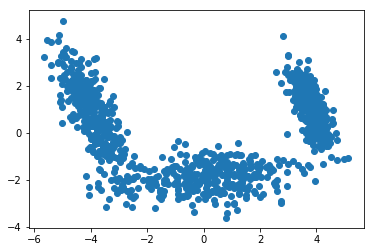

In [25]:
import matplotlib.pyplot as plt
plt.scatter(x, y)